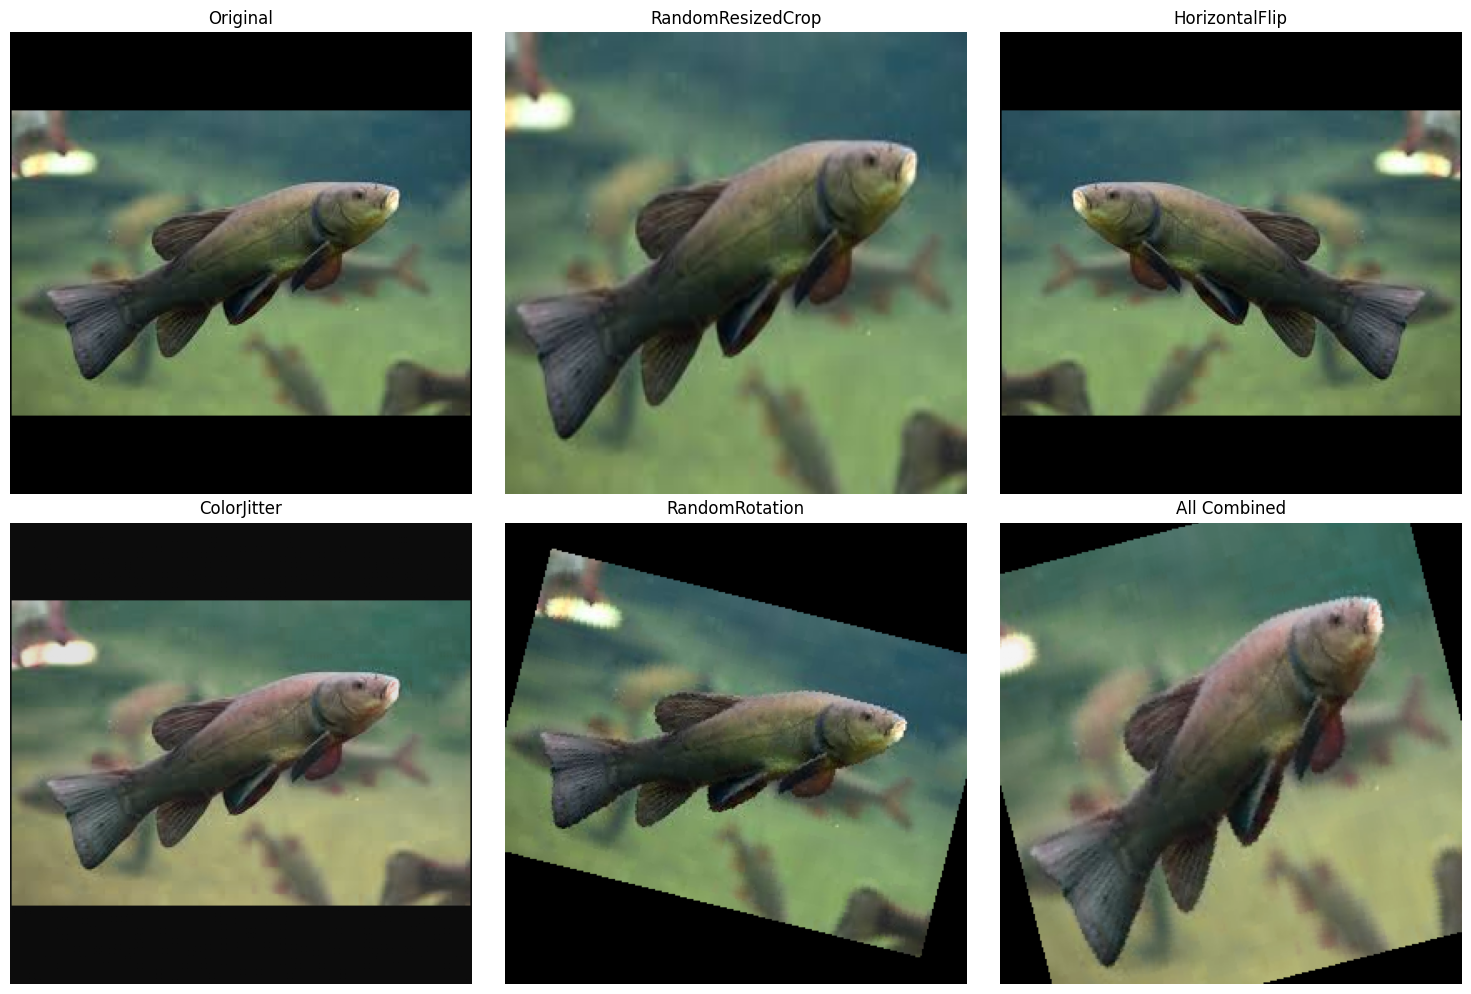

In [ ]:
import requests

from io import BytesIO

import matplotlib.pyplot as plt

import torchvision.transforms as transforms

from PIL import Image

import numpy as np



IMAGE_DIM = 277



augmentations = [

    ("Original", transforms.Compose([

        transforms.CenterCrop(IMAGE_DIM),

        transforms.ToTensor()

    ])),

    ("RandomResizedCrop", transforms.Compose([

        transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0)),

        transforms.ToTensor()

    ])),

    ("HorizontalFlip", transforms.Compose([

        transforms.CenterCrop(IMAGE_DIM),

        transforms.RandomHorizontalFlip(1),

        transforms.ToTensor()

    ])),

    ("ColorJitter", transforms.Compose([

        transforms.CenterCrop(IMAGE_DIM),

        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

        transforms.ToTensor()

    ])),

    ("RandomRotation", transforms.Compose([

        transforms.CenterCrop(IMAGE_DIM),

        transforms.RandomRotation(degrees=15),

        transforms.ToTensor()

    ])),

    ("All Combined", transforms.Compose([

        transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0)),

        transforms.RandomHorizontalFlip(),

        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

        transforms.RandomRotation(degrees=15),

        transforms.ToTensor()

    ]))

]



image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQFuAFw9qqY0WdxJ8OWNkrVKpbCZi0rXaslxg&s'

response = requests.get(image_url)

image = Image.open(BytesIO(response.content))



fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.ravel()



for i, (title, aug) in enumerate(augmentations):

    augmented_img = aug(image)  # Apply the augmentation

    augmented_img_np = augmented_img.permute(1, 2, 0).numpy()

    axs[i].imshow(np.clip(augmented_img_np, 0, 1))

    axs[i].axis('off')

    axs[i].set_title(title)



for j in range(i+1, len(axs)):

    axs[j].axis('off')



plt.tight_layout()

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader, ConcatDataset

import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
transform1 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform2 = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0)),
    transforms.Resize(28), # Resize to 28x28 to match the original image size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Add normalization
])

train_dataset1 = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform1)
train_dataset2 = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform2)
train_dataset = ConcatDataset([train_dataset1, train_dataset2])

test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform1)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

classes = train_dataset2.classes
print(f'Classes:\n{classes}')

Train dataset size: 225600
Test dataset size: 18800
Classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Iterate over the data
for x, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
def plot_results(train_losses, train_accs, test_losses, test_accs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label='Train')
    axes[0].plot(xs, test_losses, label='Test')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label='Train')
    axes[1].plot(xs, test_accs, label='Test')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [ ]:
def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader, test_loader, device=device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        test_loss, test_acc = test_step(model, criterion, test_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Test Loss = {test_loss:.3f} | Test Acc = {test_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), train_accs.append(train_acc), test_losses.append(test_loss), test_accs.append(test_acc)
    # Plot the results
    plot_results(train_losses, train_accs, test_losses, test_accs)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'test_loss': test_losses, 'test_acc': test_accs}

In [ ]:
class AlexNet1(nn.Module):

    def __init__(self, num_classes=10):

        super(AlexNet1, self).__init__()

        self.features = nn.Sequential(

            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            nn.Conv2d(64, 192, kernel_size=3, padding=1),  # 14x14 -> 14x14

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7

            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # 7x7 -> 7x7

            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 7x7 -> 7x7

            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 7x7 -> 7x7

            nn.ReLU(inplace=True),

            # No further pooling to maintain feature map size at 7x7

        )

        self.classifier = nn.Sequential(

            nn.Dropout(p=0.5),  # Dropout for regularization

            nn.Linear(256 * 7 * 7, 4096),  # Adjusted for 7x7 input

            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),  # Dropout for regularization

            nn.Linear(4096, 1024),  # Reduced for computational efficiency

            nn.ReLU(inplace=True),

            nn.Linear(1024, num_classes),  # Output for 10 classes in Fashion-MNIST

        )



    def forward(self, x):

        x = self.features(x)

        x = torch.flatten(x, 1)

        return self.classifier(x)


Train Loss = 0.293 | Train Acc = 88.95% | Test Loss = 0.341 | Test Acc = 88.28% : 100%|██████████| 10/10 [13:35<00:00, 81.59s/it]


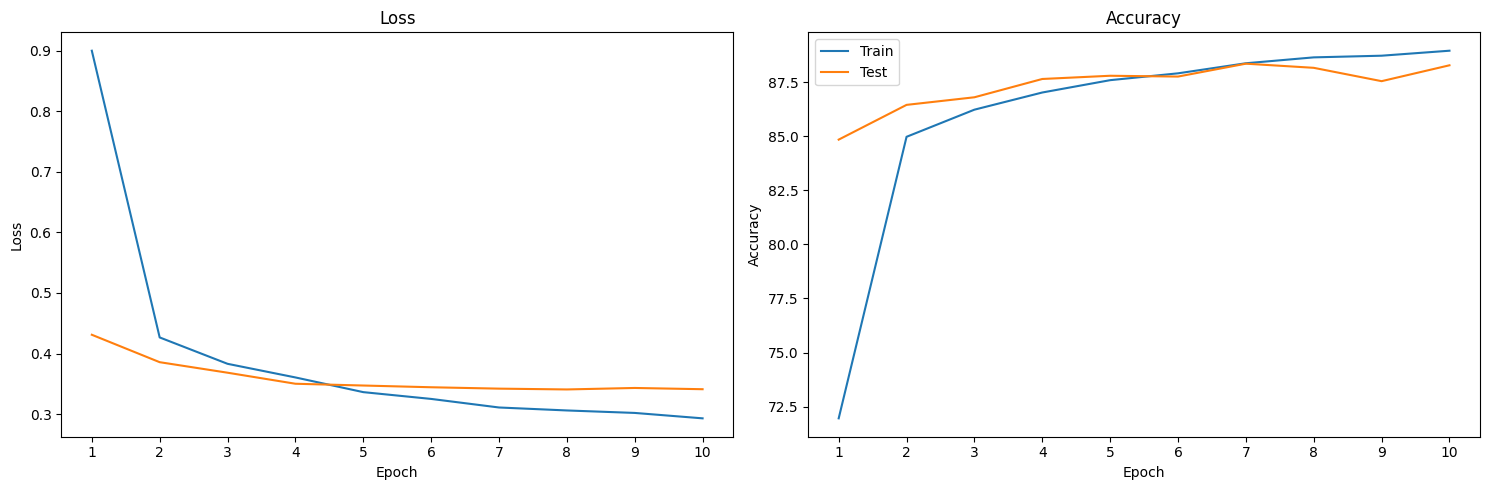

In [ ]:
model = AlexNet1(num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 10, optimizer, train_loader, test_loader)

**Transfer Learning**

In [ ]:
from matplotlib import pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets.cifar import CIFAR10

from torchsummary import summary

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, train_acc


def validate_epoch(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0.
    val_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            val_acc += (logits.argmax(dim=1) == labels).sum().item()
        val_loss /= len(dataloader)
        val_acc /= len(dataloader.dataset)
    return val_loss, val_acc


def train_model(model, train_dataloader, val_dataloader, optimizer, n_epochs, device=device):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    loss_fn = CrossEntropyLoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        val_loss, val_acc = validate_epoch(model, val_dataloader, loss_fn, device)
        history['val_loss'].append(val_loss), history['val_acc'].append(val_acc)
        pbar.set_description(f'Training Accuracy {100 * train_acc:.2f}% | Validation Accuracy {100 * val_acc:.2f}% ')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['train_loss'], label='train')
    ax1.plot(history['val_loss'], label='val')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='train')
    ax2.plot(history['val_acc'], label='val')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [ ]:
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


**ResNet18 without Pre_Training**

Training Accuracy 84.48% | Validation Accuracy 81.33% : 100%|██████████| 20/20 [08:28<00:00, 25.40s/it]


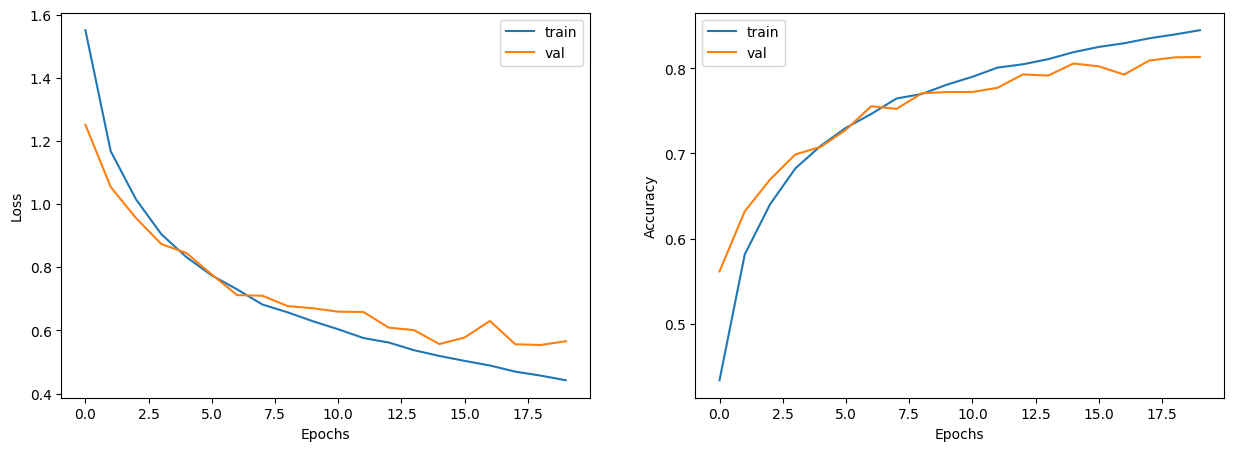

In [ ]:
resnet18 = models.resnet18(weights=None)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(classes))

resnet18 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.compile(resnet18)
optim = Adam(resnet18.parameters())

results = train_model(resnet18, trainloader, testloader, optim, n_epochs=20)
plot_history(results)

**ResNet18 with Pre-Training**

In [ ]:
resnet18 = models.resnet18(weights='DEFAULT')
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(classes))

resnet18 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.compile(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


Training Accuracy 86.66% | Validation Accuracy 83.97% : 100%|██████████| 20/20 [08:27<00:00, 25.38s/it]


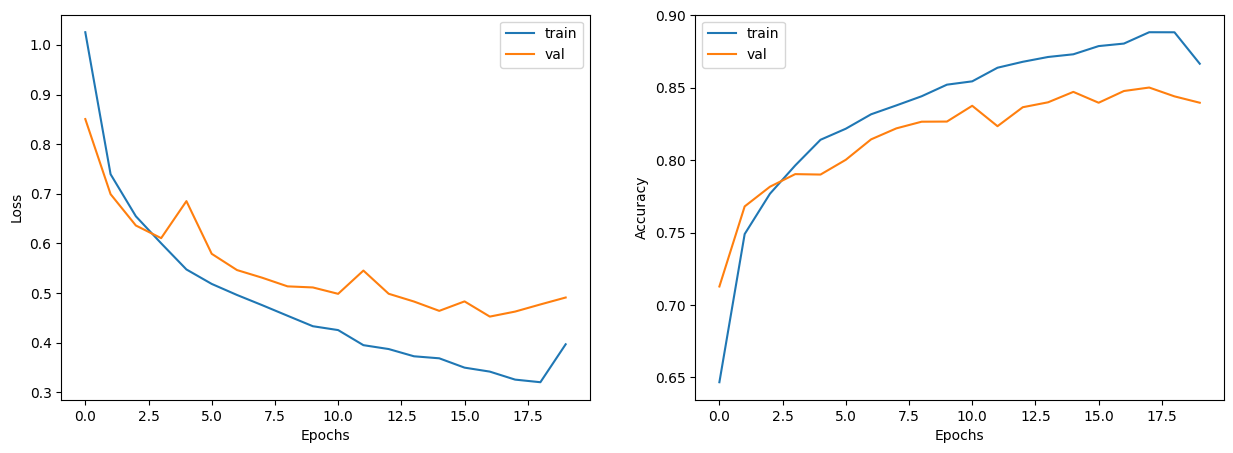

In [ ]:
optim = Adam(resnet18.parameters())
pt_results = train_model(resnet18, trainloader, testloader, optim, n_epochs=20)
plot_history(pt_results)

**Freez all the layers except for the final fully connected layer**

In [ ]:
resnet18 = models.resnet18(weights='DEFAULT')

# Freeze All Layers Except the Final Fully Connected Layer
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the Final Fully Connected Layer
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(classes))

resnet152 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.compile(resnet18)

Training Accuracy 41.81% | Validation Accuracy 40.65% : 100%|██████████| 15/15 [05:00<00:00, 20.00s/it]


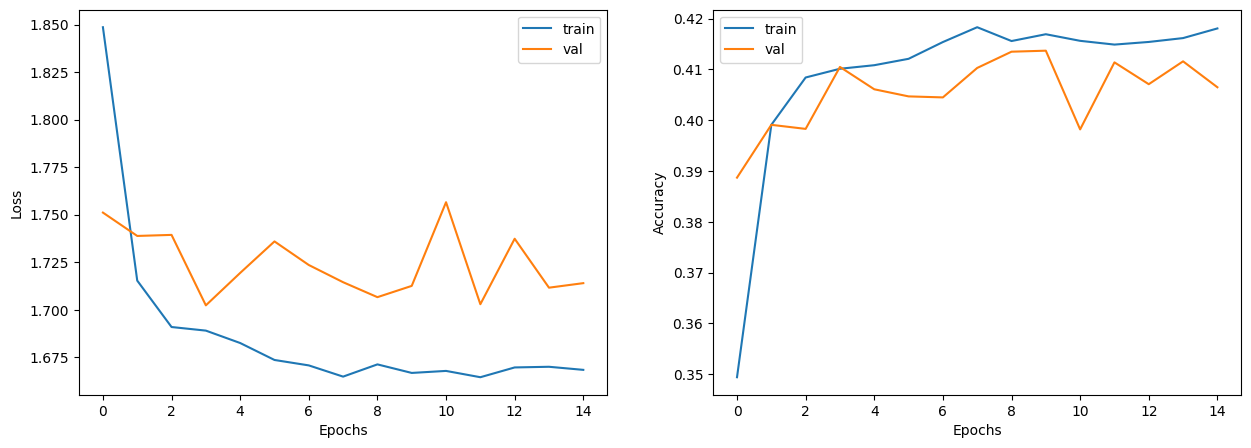

In [ ]:
optim = Adam(resnet18.fc.parameters())
results = train_model(resnet18, trainloader, testloader, optim, n_epochs=15)
plot_history(results)

**Word Embedding**


In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

def preprocess_text(text, minimum_length=1, stopword_removal=True, stopwords_domain=[], lower_case=True,
                       punctuation_removal=True):
    """
    preprocess text by removing stopwords, punctuations, and converting to lowercase, and also filter based on a min length
    for stopwords use nltk.corpus.stopwords.words('english')
    for punctuations use string.punctuation

    Parameters
    ----------
    text: str
        text to be preprocessed
    minimum_length: int
        minimum length of the token
    stopword_removal: bool
        whether to remove stopwords
    stopwords_domain: list
        list of stopwords to be removed base on domain
    lower_case: bool
        whether to convert to lowercase
    punctuation_removal: bool
        whether to remove punctuations
    """
    if lower_case:
        text = text.lower()

    if punctuation_removal:
        text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    if stopword_removal:
        stop_words = set(stopwords.words('english'))
        if stopwords_domain:
            stop_words.update(stopwords_domain)
        tokens = [word for word in tokens if word not in stop_words]

    tokens = [word for word in tokens if len(word) >= minimum_length]

    processed_text = ' '.join(tokens)

    return processed_text

In [6]:
class PreTrainedWord2Vec:
    """
    A class used fro a pre-trained Word2Vec model and generate embeddings for text data.

    Attributes
    ----------
    model: Word2Vec model
        The trained Word2Vec model.
    """

    def __init__(self, preprocessor=None, model=None):
        """
        Initializes the FastText with a preprocessor and a model.

        Parameters
        ----------
        model : Word2Vec model
        """
        self.preprocessor = preprocessor
        self.model = model



    def get_query_embedding(self, query):
        """
        Generates an embedding for the given query.

        Parameters
        ----------
        query : str
            The query to generate an embedding for.


        Returns
        -------
        np.ndarray
            The embedding for the query.
        """
        if self.preprocessor:
            query = self.preprocessor(query)

        word_vectors = []

        for word in query.split(' '):
            if word in model:
                word_vectors.append(model[word])


        sentence_vector = np.mean(word_vectors, axis=0)
        return sentence_vector


    def analogy(self, word1, word2, word3):
        """
        Perform an analogy task: word1 is to word2 as word3 is to __.

        Args:
            word1 (str): The first word in the analogy.
            word2 (str): The second word in the analogy.
            word3 (str): The third word in the analogy.

        Returns:
            str: The word that completes the analogy.
        """
        new_word1 = self.preprocessor(word1)
        new_word2 = self.preprocessor(word2)
        new_word3 = self.preprocessor(word3)
        word1_emb = self.model[new_word1]
        word2_emb = self.model[new_word2]
        word3_emb = self.model[new_word3]

        result = word3_emb + (word2_emb - word1_emb)

        vocab_vectors = {word: self.model[word] for word in list(self.model.index_to_key)}

        input_words = {word1, word2, word3}
        possible_results = {word: vec for word, vec in vocab_vectors.items() if word not in input_words}

        nearest_word = max(possible_results, key=lambda word: np.dot(possible_results[word], result) / (
                    np.linalg.norm(possible_results[word]) * np.linalg.norm(result)))

        return nearest_word

    def plot_words(self, words):
        """
        Plots the given words in a 2D space using PCA for dimensionality reduction.

        Parameters
        ----------
        words : list of str
            A list of words to be plotted.
        """
        # Collect the word vectors for the specified words
        word_vectors = [self.model[word] for word in words if word in self.model]

        # Apply PCA to reduce the dimensions to 2D
        pca = PCA(n_components=2)
        word_vecs_2d = pca.fit_transform(word_vectors)

        # Plotting the words
        plt.figure(figsize=(10, 7))
        for i, word in enumerate(words):
            if word in self.model:
                plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1])
                plt.text(word_vecs_2d[i, 0] + 0.01, word_vecs_2d[i, 1] + 0.01, word, fontsize=12)

        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.title("Word Embeddings in 2D space")
        plt.grid(True)
        plt.show()

In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requir

In [1]:
import gensim.downloader as api
# Load a pre-trained skip-gram Word2Vec model (Google News model)
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [70]:
h = model['king','I']
print(h.shape)

word_vectors = []
for word in 'I am happy'.split(' '):
    if word in model:
          word_vectors.append(model[word])

sentence_vector = np.mean(word_vectors, axis=0)

word_vectors[2].shape



(2, 300)


(300,)

In [9]:
w2v = PreTrainedWord2Vec(preprocess_text, model)

In [13]:
import numpy as np
print(10 * "*" + "Similarity" + 10 * "*")
word = 'queen'
neighbors = w2v.model.most_similar(word)

for neighbor in neighbors:
    print(f"Word: {neighbor[1]}, Similarity: {neighbor[0]}")

print(10 * "*" + "Analogy" + 10 * "*")
word1 = "man"
word2 = "woman"
word3 = "boy"
print(f"Similarity between {word1} and {word2} is like similarity between {word3} and {w2v.analogy(word1, word2, word3)}")


**********Similarity**********
Word: 0.739944338798523, Similarity: queens
Word: 0.7070532441139221, Similarity: princess
Word: 0.6510956883430481, Similarity: king
Word: 0.6383602023124695, Similarity: monarch
Word: 0.6357026696205139, Similarity: very_pampered_McElhatton
Word: 0.6163407564163208, Similarity: Queen
Word: 0.6060680150985718, Similarity: NYC_anglophiles_aflutter
Word: 0.5923796892166138, Similarity: Queen_Consort
Word: 0.5908074975013733, Similarity: princesses
Word: 0.5637185573577881, Similarity: royal
**********Analogy**********
Similarity between man and woman is like similarity between boy and girl


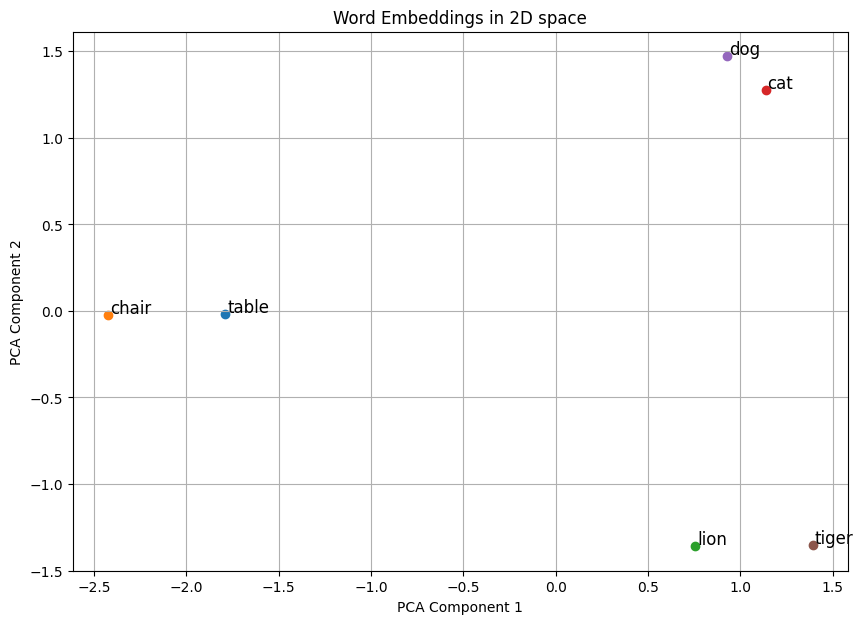

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

w2v.plot_words(['table', 'chair', 'lion', 'cat','dog', 'tiger'])

**Sentiment Prediction**

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
#import fasttext
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np

# 1. DATASET: Positive and Negative Examples
positive_examples = [
    "I absolutely loved the movie!",
    "The food was delicious and the service was excellent.",
    "This product exceeded my expectations.",
    "I had a fantastic time at the concert.",
    "The weather was beautiful during our vacation.",
    "The customer support team was incredibly helpful.",
    "I would definitely recommend this restaurant.",
    "The book was a joy to read from start to finish.",
    "I'm very happy with my purchase.",
    "The experience was truly unforgettable."
]

negative_examples = [
    "The movie was terrible and a complete waste of time.",
    "The food was cold and the service was slow.",
    "I was very disappointed with the quality of this product.",
    "The concert was boring and not worth the money.",
    "The weather ruined our entire trip.",
    "The customer support team was unhelpful and rude.",
    "I will never visit this restaurant again.",
    "The book was poorly written and hard to follow.",
    "I'm extremely dissatisfied with my purchase.",
    "The experience was awful and I regret it."
]

positive_labels = [1] * len(positive_examples)
negative_labels = [0] * len(negative_examples)

sentences = positive_examples + negative_examples
labels = positive_labels + negative_labels

# 2. Shuffle and Split into Training and Validation Sets
dataset = list(zip(sentences, labels))
random.shuffle(dataset)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

print(f'Train dataset size: {len(train_data)}')
print(f'Test dataset size: {len(val_data)}')

Train dataset size: 16
Test dataset size: 4


In [37]:
# 4. Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, data, word2vec_model):
        self.data = data
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, label = self.data[idx]
        embedding = self.get_embedding(sentence)
        return embedding, torch.tensor(label, dtype=torch.float)

    def get_embedding(self, sentence):
        """Get word2vec embedding for a given sentence"""
        embedding = self.word2vec_model.get_query_embedding(sentence)
        return torch.tensor(embedding).float()

# 5. Model Definition
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [40]:
# 6. Hyperparameters and Dataset Preparation
embedding_dim = 300  # Word2Vec embedding size
train_dataset = SentimentDataset(train_data, w2v)
val_dataset = SentimentDataset(val_data, w2v)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# 7. Training Setup
nn_model = SentimentClassifier(embedding_dim)
criterion = nn.BCELoss()  # Binary cross entropy loss for binary classification
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# 8. Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    nn_model.train()
    running_loss = 0.0
    for embeddings, labels in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(embeddings)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    nn_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            outputs = nn_model(embeddings)
            predicted = (outputs.squeeze() >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch [1/50], Loss: 2.7665, Validation Accuracy: 25.00%
Epoch [2/50], Loss: 2.7061, Validation Accuracy: 25.00%
Epoch [3/50], Loss: 2.6591, Validation Accuracy: 25.00%
Epoch [4/50], Loss: 2.6137, Validation Accuracy: 25.00%
Epoch [5/50], Loss: 2.5660, Validation Accuracy: 25.00%
Epoch [6/50], Loss: 2.5141, Validation Accuracy: 25.00%
Epoch [7/50], Loss: 2.4608, Validation Accuracy: 25.00%
Epoch [8/50], Loss: 2.3912, Validation Accuracy: 25.00%
Epoch [9/50], Loss: 2.3254, Validation Accuracy: 25.00%
Epoch [10/50], Loss: 2.2497, Validation Accuracy: 25.00%
Epoch [11/50], Loss: 2.1658, Validation Accuracy: 50.00%
Epoch [12/50], Loss: 2.0782, Validation Accuracy: 50.00%
Epoch [13/50], Loss: 1.9885, Validation Accuracy: 50.00%
Epoch [14/50], Loss: 1.8957, Validation Accuracy: 50.00%
Epoch [15/50], Loss: 1.7982, Validation Accuracy: 50.00%
Epoch [16/50], Loss: 1.7088, Validation Accuracy: 50.00%
Epoch [17/50], Loss: 1.6059, Validation Accuracy: 50.00%
Epoch [18/50], Loss: 1.5088, Validation 

In [41]:
def predict_sentiment(nn_model, sentence, w2v):
    """
    Predicts the sentiment of a given sentence using the trained model.

    Parameters
    ----------
    nn_model : SentimentClassifier
        The trained sentiment classification model.
    sentence : str
        The input sentence to classify.
    w2v : Word2Vec model
        The model used to generate embeddings.

    Returns
    -------
    str
        The predicted sentiment ('positive' or 'negative').
    """
    # Step 1: Get FastText embedding for the sentence
    embedding = w2v.get_query_embedding(sentence)
    embedding = torch.tensor(embedding).float().unsqueeze(0)  # Add batch dimension

    # Step 2: Pass the embedding through the model to get prediction
    nn_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = nn_model(embedding)

    # Step 3: Interpret the result
    prediction = output.item()  # Get the output as a scalar value
    sentiment = "positive" if prediction >= 0.5 else "negative"

    return sentiment

In [42]:
# Example usage
query_sentence = "The movie was terrible and a i hated it"
predicted_sentiment = predict_sentiment(nn_model, query_sentence, w2v)
print(f"Sentiment of the query '{query_sentence}': {predicted_sentiment}")

Sentiment of the query 'The movie was terrible and a i hated it': negative


In [45]:
# Example usage
query_sentence = "The movie was amazing and i loved it"
predicted_sentiment = predict_sentiment(nn_model, query_sentence, w2v)
print(f"Sentiment of the query '{query_sentence}': {predicted_sentiment}")

Sentiment of the query 'The movie was amazing and i loved it': positive
